In [1]:
import glob
import csv
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
!pip install funcy
import funcy
from funcy import print_durations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.cuda.amp import GradScaler
torch.backends.cudnn.benchmark = True
import datetime
import gc
import pickle
from torchsummary import summary

/opt/conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defaulting to user installation because normal site-packages is not writeable


In [16]:
start_date = '1980-01-01'

In [3]:
returns_df = pd.read_csv('returns.csv',index_col=0).loc[start_date:]
# returns_df = returns_df.dropna(axis=0,thresh=500).dropna(axis=1,thresh=500)
equity_idx = returns_df.columns
date_idx = returns_df.index
returns_df = returns_df.clip(returns_df.quantile(0.01,axis=1),returns_df.quantile(0.99,axis=1),axis=0)
returns_df

,0081A,0091A,0099A,0127A,0138A,0146A,0153A,0183B,0223B,0230B,...,ZVXI,ZWRK,ZWS,ZXAIY,ZY,ZYME,ZYNE,ZYXI,ZZ,ZZ1
datadate,,,,,,,,,,,,,,,,,,,,,
1980-01-31,NaN,0.012579,NaN,0.068182,0.039548,NaN,NaN,NaN,0.007752,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137500
1980-02-29,NaN,-0.006211,NaN,0.000000,NaN,NaN,NaN,NaN,-0.086462,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.164835
1980-03-31,NaN,-0.306250,NaN,0.007092,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.118421
1980-04-30,NaN,0.252252,NaN,-0.126761,NaN,NaN,NaN,NaN,0.139130,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.029851
1980-05-31,NaN,0.071942,NaN,0.177419,NaN,NaN,NaN,NaN,0.036336,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001025,-0.033076,0.001111,-0.145283,-0.096180,-0.096606,0.021548,NaN,NaN
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001026,0.038516,0.054384,-0.261589,-0.184983,-0.167630,-0.221094,NaN,NaN
2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.004620,-0.160989,0.084211,-0.222720,-0.456986,-0.093750,-0.115145,NaN,NaN


In [4]:
macro_df = pd.read_csv('macro_features_final_dropna.csv',index_col=0).loc[start_date:]
macro_df = macro_df.dropna(axis=0,how='all')
macro_df = macro_df.dropna(axis=1,how='all')
# features_idx = macro_df.columns
macro_df

,W875RX1,DPCERA3M086SBEA,CMRMTSPL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,...,RNA,ROA,ROE,SGA2S,D2A,AC,OA,OL,PCM,AT
rdq,,,,,,,,,,,,,,,,,,,,,
1984-03-31,5542.4,43.313,625030.688,53.7313,59.7733,58.3060,70.0584,49.1906,79.4306,32.2755,...,0.094449,0.050187,0.117328,0.681474,0.037466,0.001090,-0.000767,1.091945,-1.399036,91.9985
1984-06-30,5644.3,44.151,639093.221,54.5095,60.5822,58.9702,69.9638,48.8344,79.5199,33.0531,...,0.100075,0.053498,0.122086,0.673583,0.037448,0.000000,-0.000824,1.096514,-1.340794,87.9295
1985-08-31,5845.1,46.763,659042.751,54.8269,62.0818,60.5334,70.5367,49.1804,80.1992,34.4353,...,0.092896,0.047344,0.130653,0.693678,0.038749,-0.003140,-0.001191,1.095180,-1.258783,80.6030
1985-11-30,5910.7,46.791,659509.852,55.0381,62.5036,61.0456,71.2028,50.0607,80.7057,34.5959,...,0.090193,0.044600,0.127164,0.700228,0.039440,0.000000,-0.001074,1.076283,-1.265303,80.7480
1986-05-31,6043.6,47.980,669565.217,55.2556,63.0492,61.2452,72.7183,51.0468,82.4684,33.9200,...,0.084047,0.039336,0.134048,0.710053,0.039774,0.000000,-0.001109,1.075452,-1.252150,80.6865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,14406.3,125.640,1572476.000,102.0374,101.2518,101.6865,100.8504,104.7309,99.7321,95.8557,...,0.049653,0.013872,0.069816,0.659218,0.022986,0.003672,-0.000196,0.474068,-0.202465,1124.9105
2021-12-31,14398.0,123.868,1562935.000,101.6402,100.7942,101.2701,100.2659,103.9276,99.2067,95.7659,...,0.049773,0.013892,0.069949,0.659782,0.022915,0.004113,-0.000202,0.475670,-0.205471,1131.1950
2022-01-31,14363.1,126.504,1594543.000,102.6863,101.8134,102.4001,101.8697,106.0272,100.6766,95.4291,...,0.049706,0.013879,0.070214,0.659905,0.022857,0.003672,-0.000198,0.478045,-0.212693,1136.5500


In [5]:
feat_comb_df = pd.read_csv('features_full_final.csv').set_index(['tic','rdq']).drop(['FYEARQ','FQTR'],axis=1)
feat_comb_df = feat_comb_df[sorted(feat_comb_df.columns)]
feat_comb_df

A2ME        AC        AT       ATO      BEME      BETA  \
tic   rdq                                                                      
0081A 1996-12-31       NaN       NaN       NaN       NaN       NaN       NaN   
      1997-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
      1997-02-28  0.564765       NaN   140.274       NaN       NaN       NaN   
      1997-03-31  0.564765       NaN   140.274       NaN       NaN       NaN   
      1997-04-30  0.529462       NaN   146.767       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
ZZ    2012-10-31  5.840417  0.377852   971.509  0.888069 -0.316438  0.503049   
      2012-11-30  5.840417  0.377852   971.509  0.888069 -0.316438  0.503035   
      2012-12-31  5.840417  0.377852   971.509  0.888069 -0.316438  0.500307   
      2013-01-31  4.440987  0.489857  1005.345  1.081163 -0.253677  0.501021   
      2013-02-28  4.440987  0.489857  1005.345  1.081163 -0.253677  0.500922   

                         C  CF      CF2P       CTO  ...  REL2HIGH  RESID_VAR  \
tic   rdq                                           ...                        
0081A 1996-12-31       NaN NaN       NaN       NaN  ...       NaN        NaN   
      1997-01-31       NaN NaN       NaN       NaN  ...       NaN        NaN   
      1997-02-28  0.011328 NaN       NaN       NaN  ...       NaN   1.896184   
      1997-03-31  0.011328 NaN       NaN       NaN  ...       NaN   2.542292   
      1997-04-30  0.014431 NaN       NaN       NaN  ...       NaN   2.653953   
...                    ...  ..       ...       ...  ...       ...        ...   
ZZ    2012-10-31  0.091438 NaN -0.015174  0.549053  ...  0.910204   1.851362   
      2012-11-30  0.091438 NaN -0.015174  0.549053  ...  0.885714   0.619041   
      2012-12-31  0.091438 NaN -0.015174  0.549053  ...  0.885714   0.598993   
      2013-01-31  0.127473 NaN  0.042809  0.614895  ...  0.881633   0.542592   
      2013-02-28  0.127473 NaN  0.042809  0.614895  ...  0.889796   0.429795   

                       RNA       ROA       ROE       S2P     SGA2S   ST_REV  \
tic   rdq                                                                     
0081A 1996-12-31       NaN       NaN       NaN       NaN       NaN      NaN   
      1997-01-31       NaN       NaN       NaN       NaN       NaN      NaN   
      1997-02-28       NaN       NaN       NaN       NaN       NaN   1.5583   
      1997-03-31       NaN       NaN       NaN       NaN       NaN  10.7738   
      1997-04-30       NaN       NaN       NaN       NaN       NaN  -2.7778   
...                    ...       ...       ...       ...       ...      ...   
ZZ    2012-10-31  0.118627 -0.009920  0.167075  7.568810  0.818410  36.2500   
      2012-11-30  0.118627 -0.009920  0.167075  7.568810  0.818410   2.2936   
      2012-12-31  0.118627 -0.009920  0.167075  7.568810  0.818410  -2.6906   
      2013-01-31  0.167337  0.002145 -0.024645  5.954049  0.798554   0.0000   
      2013-02-28  0.167337  0.002145 -0.024645  5.954049  0.798554  -0.4608   

                       SUV  VARIANCE  
tic   rdq                             
0081A 1996-12-31       NaN       NaN  
      1997-01-31       NaN       NaN  
      1997-02-28       NaN  4.225542  
      1997-03-31       NaN  6.975184  
      1997-04-30       NaN  7.456677  
...                    ...       ...  
ZZ    2012-10-31  0.669890  4.256721  
      2012-11-30 -0.125130  0.458271  
      2012-12-31  0.062727  0.420686  
      2013-01-31 -1.501970  0.311550  
      2013-02-28 -0.227316  0.230933  

[3692558 rows x 45 columns]

In [6]:
MIN_AVAILABLE_FEATURES = feat_comb_df.shape[1]//2

full_df_lst = []
for date in tqdm(date_idx):
    sub = feat_comb_df.loc[feat_comb_df.index.get_level_values(1) <= date]
    sub = sub.groupby(sub.index.get_level_values('tic')).last(1)
    sub = sub.transpose()
    
    sub = sub.rank(pct=True,axis=1)*2-1
    idx = (sub.isna().sum(axis=0) >= MIN_AVAILABLE_FEATURES).index
    sub = sub[idx].fillna(0)
    
#     sub = sub.fillna(sub.median(axis=1),axis=0)
    
    sub['date'] = date
    sub =  sub.set_index(['date',sub.index])
    
    full_df_lst.append(sub)
    
del feat_comb_df
gc.collect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [09:23<00:00,  1.11s/it]


0

# Train Test Split

In [7]:
class AEDataSet(torch.utils.data.Dataset):
    def __init__(self, macro_df, full_df_lst, returns_df, date_idx, start_i, end_i, rhs_input_assets=False,lag=1):
        self.full_df_lst = full_df_lst
        self.macro_df_idx = macro_df.index
        self.macro_df = macro_df.to_numpy()
        self.macro_df[np.isnan(self.macro_df)] = 0
        self.returns_df = returns_df
        self.date_idx = date_idx
        self.start_i, self.end_i = start_i, end_i
        self.rhs_input_assets = rhs_input_assets
        self.epsilon=1e-5
        self.lag=lag
        
        self.output_date_idx = date_idx[start_i+lag:end_i]
        
    def __len__(self):
        return self.end_i - self.start_i - self.lag
    
    def __getitem__(self, idx):
        input_idx = idx
        idx += self.start_i+self.lag
        date = self.date_idx[idx] # returns date
        
        macro = self.macro_df
        
        mask = ~np.isnan(self.returns_df.loc[date].to_numpy())
        traded_assets_idx = self.returns_df.columns[mask]
        
        lhs = self.full_df_lst[idx - self.lag]
        lhs_idx = lhs.columns
        
        comb_idx = traded_assets_idx.intersection(lhs_idx)
        
        lhs = lhs.reindex(comb_idx,axis=1,fill_value=0).to_numpy()
        
        rhs_tmp = self.returns_df.loc[date,comb_idx]
        rhs_tmp = rhs_tmp.clip(rhs_tmp.quantile(0.01),rhs_tmp.quantile(0.99))
        output = rhs_tmp.to_numpy()

        lhs_tmp = np.concatenate([lhs,np.expand_dims(np.ones(lhs.shape[1]),0)],axis=0)
        
        if self.rhs_input_assets:
            rhs = output
        else:
            try:
#               
                # Causing singular error. Changing to pseudo inverse
                rhs = (np.linalg.pinv(lhs_tmp @ lhs_tmp.T) @ lhs_tmp) @ rhs_tmp
#               
            except Exception as e:
                print("idx:",input_idx)
                print(e)
#                 return self.full_df_lst[idx - self.lag].reindex(traded_assets_idx,axis=1,fill_value=0), rhs_tmp
                # return lhs,lhs_tmp,output
                raise e
#             rhs.index = lhs_tmp.index
#             rhs = rhs.reindex(self.alpha_names,fill_value=0).clip(-5e4,5e4)
#             rhs['equal'] = equal_weighted_portfolio
#             rhs = rhs.to_numpy()
        return macro,self.macro_df_idx,date,lhs,rhs,output,comb_idx
        
        
def collate_fn(batch):
    macro = batch[0][0]
    macro_df_idx = batch[0][1]
    dates = [i for _,_,i,_,_,_,_ in batch]
    dates = [np.where(macro_df_idx == np.max(macro_df_idx[macro_df_idx <= i]))[0][0] for i in dates]
    len_x = [len(output) for _,_,_,_,_,output,_ in batch]
    full_size = max(len_x)
#     print(full_size)
    
    
    batch_lhs = [nn.functional.pad(torch.Tensor(lhs),pad=(0,full_size-lhs.shape[1],0,0)) for macro,_,_,lhs,rhs,output,_ in batch]
    batch_rhs = [torch.Tensor(rhs) for macro,_,_,lhs,rhs,output,_ in batch]
    batch_output = [nn.functional.pad(torch.Tensor(output),pad=(0,full_size-len(output))) for macro,_,_,lhs,rhs,output,_ in batch]
    batch_assets = [idx for macro,_,_,lhs,rhs,output,idx in batch]

    
    return torch.from_numpy(macro), torch.tensor(dates),\
        torch.cat([x.unsqueeze(0) for x in batch_lhs]),\
        torch.cat([x.unsqueeze(0) for x in batch_rhs]),\
        torch.cat([x.unsqueeze(0) for x in batch_output]), torch.tensor(len_x), batch_assets

# Conditional Autoencoder

With layers:

In [8]:
def buildListFromConfigs(config, inp_size, out_size, batch_norm=True, dropout=0.5, initialization=False, nonlinear=nn.SELU):
    layer_lst = []
    for i, v in enumerate(list(config)+[out_size]):
        if batch_norm and i > 0: #generally no batch norm before the model starts
            layer_lst.append(nn.LayerNorm(inp_size))
        if dropout > 1e-8 and i > 0:
            layer_lst.append(nn.Dropout(dropout))
        layer_lst.append(nn.Linear(inp_size, v, bias=True))
        if initialization:
            nn.init.kaiming_normal_(layer_lst[-1].weight,mode='fan_in',nonlinearity='linear')
        if i < len(config):
            layer_lst.append(nonlinear())
        inp_size = v
    return layer_lst, inp_size

class BuildLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, proj_size=None):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for i in range(num_layers)]) #nn.ModuleList([LockedDropout(dropout) for i in range(num_layers)])
        layers = []
        for i in range(num_layers):
            layers.append(nn.LSTMCell(input_size, hidden_size))
            input_size = hidden_size
        self.layers = nn.ModuleList(layers)
        self.final = nn.Linear(input_size, proj_size) if proj_size is not None and input_size != proj_size else nn.Identity()
    
    def forward(self, data, hidden=None):
        if hidden is None:
            hidden = [None for i in range(self.num_layers)]
        for i in range(self.num_layers):
            data = self.dropout[i](data)
            data, hidden[i] = self.layers[i](data, hidden[i])
        data = self.final(data)
        return data, hidden
        

class ConditionalAutoEncoder(nn.Module):
    # starting macro is the state of the last 13 months. For training, set it to None (equivalent to setting it to a torch of zeros).
    # However, since testing data is low, run the macro net on the past <attention_span> months and send that. First month's data is not used.
    # Requires a <attention_span>*<n_macro_size> torch vector in the same device as the model, where n_macro_size is the output of the n_hidden_macro net.
    def __init__(self, n_alphas, n_factors, n_macro, n_hidden_macro, n_hidden_lhs, n_hidden_rhs, attention_vs_lstm='attention', starting_macro = None, starting_rhs = None,
                    batch_norm_lhs=True, batch_norm_rhs=False, dropout_p=0, initialization=True, rhs_input_assets = False, rhs_activation = True,
                    bn_momentum=0.1, bn_track_running_stats = True, macro_attention_span=1, rhs_attention_span=1, num_lstm_layers=1):
        # n_assets can be assets or portfolios:
            # In both cases, we are interested in asset return or portfolio return on the RHS
            # LHS is the original factor 
        super(ConditionalAutoEncoder, self).__init__()

        self.n_alphas = n_alphas
        self.n_factors = n_factors
        self.n_hidden_lhs = list(n_hidden_lhs)
        self.n_hidden_rhs = list(n_hidden_rhs)
        self.n_macro = n_macro
        self.n_hidden_macro = n_hidden_macro
        self.lstm = attention_vs_lstm != 'attention'

        if attention_vs_lstm == 'attention':
            self.prev_macro = torch.zeros((macro_attention_span, n_factors), requires_grad=True) if starting_macro is None else starting_macro
            self.prev_rhs   = torch.zeros((rhs_attention_span, n_factors), requires_grad=True) if starting_rhs is None else starting_rhs
            self.macro_attention_span = macro_attention_span
            self.rhs_attention_span = rhs_attention_span
            #attention_lst = buildListFromConfigs(n_hidden_macro, n_macro+macro_attention_span*n_factors + rhs_attention_span*n_factors, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            attention_lst, _ = buildListFromConfigs(n_hidden_macro, n_macro+macro_attention_span*n_factors + rhs_attention_span*n_factors, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            self.macro = nn.Sequential(*attention_lst)
        else:
            attention_lst, _ = buildListFromConfigs(n_hidden_macro, n_macro, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            self.macro = nn.Sequential(*attention_lst)
            self.macro_lstm = nn.LSTM(n_factors, n_factors, num_lstm_layers, dropout=dropout_p) #BuildLSTM(n_factors, n_factors, num_lstm_layers)

        
        lhs_lst, _ = buildListFromConfigs(n_hidden_lhs, n_alphas, n_factors, batch_norm_lhs, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
        rhs_lst, _ = buildListFromConfigs(n_hidden_rhs, n_alphas+1, n_factors, batch_norm_rhs, dropout=dropout_p, initialization=True, nonlinear=nn.SELU if rhs_activation else nn.Identity)
        if rhs_activation:
            rhs_lst.append(nn.SELU()) #Still not sold on this

        
        self.lhs = nn.Sequential(*lhs_lst)
        self.rhs = nn.Sequential(*rhs_lst)
    
    def run_through_lhs(self, data):
        #y_lhs_lst = []
        #for i in range(x_lhs.shape[2]):
        #    y_cur = self.lhs(x_lhs[:,:,i])
        #    y_cur = torch.unsqueeze(y_cur,2)
        #    y_lhs_lst.append(y_cur)
        #y_lhs = torch.cat(y_lhs_lst,dim=2)

        shape = data.shape
        data = data.permute(0, 2, 1).reshape(-1, shape[1])
        out = self.lhs(data)
        return out.reshape(shape[0], shape[2], -1).permute(0, 2, 1)
    
    def run_through_macro(self, x_macro, y_rhs, idx):
        if self.lstm:
            y_macro = self.macro(x_macro[:, :])
            y_macro, hidden = self.macro_lstm(y_macro[None, :, :])
            y_macro = torch.sigmoid(y_macro[0, idx, :][:, :, None])
        else:
            # If using Attention, store prev_macro and prev_rhs outside like lstm
            macro = torch.cat((x_macro, self.prev_macro.reshape(1, -1), self.prev_rhs.reshape(1, -1)))
            y_macro = self.macro(macro)
            hidden = None
            self.prev_macro = torch.roll(self.prev_macro, -1, 0)
            self.prev_macro[-1] = y_macro
            self.prev_rhs = torch.roll(self.prev_rhs, -1, 0)
            self.prev_rhs[-1] = y_rhs
        return y_macro, hidden

    def forward(self, x_macro, macro_idx, x_lhs, x_rhs):
        y_lhs = self.run_through_lhs(x_lhs)
        y_rhs = self.rhs(x_rhs).unsqueeze(dim=2)
        self.last_rhs_factors = y_rhs
        y_macro, hidden = self.run_through_macro(x_macro, y_rhs, macro_idx)
        out = y_lhs*y_rhs*y_macro
        out = torch.sum(out, dim=1) #Double check this
        return out, y_rhs, y_macro

    def forward_given_factors(self, x_macro, macro_idx, x_lhs, factors):
        y_lhs = self.run_through_lhs(x_lhs)
        y_rhs = factors
        y_macro, hidden = self.run_through_macro(x_macro, y_rhs, macro_idx)
        #out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
        out = torch.sum(y_lhs*y_rhs*y_macro, dim=1) #Double check this
        return out

LSTM only

In [21]:
def buildListFromConfigs(config, inp_size, out_size, batch_norm=True, dropout=0.5, initialization=False, nonlinear=nn.SELU):
    layer_lst = []
    for i, v in enumerate(list(config)+[out_size]):
        if batch_norm and i > 0: #generally no batch norm before the model starts
            layer_lst.append(nn.LayerNorm(inp_size))
        if dropout > 1e-8 and i > 0:
            layer_lst.append(nn.Dropout(dropout))
        layer_lst.append(nn.Linear(inp_size, v, bias=True))
        if initialization:
            nn.init.kaiming_normal_(layer_lst[-1].weight,mode='fan_in',nonlinearity='linear')
        if i < len(config):
            layer_lst.append(nonlinear())
        inp_size = v
    return layer_lst, inp_size

class BuildLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, proj_size=None):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for i in range(num_layers)]) #nn.ModuleList([LockedDropout(dropout) for i in range(num_layers)])
        layers = []
        for i in range(num_layers):
            layers.append(nn.LSTMCell(input_size, hidden_size))
            input_size = hidden_size
        self.layers = nn.ModuleList(layers)
        self.final = nn.Linear(input_size, proj_size) if proj_size is not None and input_size != proj_size else nn.Identity()
    
    def forward(self, data, hidden=None):
        if hidden is None:
            hidden = [None for i in range(self.num_layers)]
        for i in range(self.num_layers):
            data = self.dropout[i](data)
            data, hidden[i] = self.layers[i](data, hidden[i])
        data = self.final(data)
        return data, hidden
        

class ConditionalAutoEncoder(nn.Module):
    # starting macro is the state of the last 13 months. For training, set it to None (equivalent to setting it to a torch of zeros).
    # However, since testing data is low, run the macro net on the past <attention_span> months and send that. First month's data is not used.
    # Requires a <attention_span>*<n_macro_size> torch vector in the same device as the model, where n_macro_size is the output of the n_hidden_macro net.
    def __init__(self, n_alphas, n_factors, n_macro, n_hidden_macro, n_hidden_lhs, n_hidden_rhs, attention_vs_lstm='attention', starting_macro = None, starting_rhs = None,
                    batch_norm_lhs=True, batch_norm_rhs=False, dropout_p=0, initialization=True, rhs_input_assets = False, rhs_activation = True,
                    bn_momentum=0.1, bn_track_running_stats = True, macro_attention_span=1, rhs_attention_span=1, num_lstm_layers=1):
        # n_assets can be assets or portfolios:
            # In both cases, we are interested in asset return or portfolio return on the RHS
            # LHS is the original factor 
        super(ConditionalAutoEncoder, self).__init__()

        self.n_alphas = n_alphas
        self.n_factors = n_factors
        self.n_hidden_lhs = list(n_hidden_lhs)
        self.n_hidden_rhs = list(n_hidden_rhs)
        self.n_macro = n_macro
        self.n_hidden_macro = n_hidden_macro
        self.lstm = attention_vs_lstm != 'attention'

        if attention_vs_lstm == 'attention':
            self.prev_macro = torch.zeros((macro_attention_span, n_factors), requires_grad=True) if starting_macro is None else starting_macro
            self.prev_rhs   = torch.zeros((rhs_attention_span, n_factors), requires_grad=True) if starting_rhs is None else starting_rhs
            self.macro_attention_span = macro_attention_span
            self.rhs_attention_span = rhs_attention_span
            #attention_lst = buildListFromConfigs(n_hidden_macro, n_macro+macro_attention_span*n_factors + rhs_attention_span*n_factors, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            attention_lst, _ = buildListFromConfigs(n_hidden_macro, n_macro+macro_attention_span*n_factors + rhs_attention_span*n_factors, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            self.macro = nn.Sequential(*attention_lst)
        else:
            #attention_lst, _ = buildListFromConfigs(n_hidden_macro, n_macro, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            self.macro = nn.Identity() #nn.Sequential(*attention_lst)
            self.macro_lstm = nn.LSTM(n_macro, n_factors, num_lstm_layers, dropout=dropout_p) #BuildLSTM(n_factors, n_factors, num_lstm_layers)

        
        lhs_lst, _ = buildListFromConfigs(n_hidden_lhs, n_alphas, n_factors, batch_norm_lhs, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
        rhs_lst, _ = buildListFromConfigs(n_hidden_rhs, n_alphas+1, n_factors, batch_norm_rhs, dropout=dropout_p, initialization=True, nonlinear=nn.SELU if rhs_activation else nn.Identity)
        if rhs_activation:
            rhs_lst.append(nn.SELU()) #Still not sold on this

        
        self.lhs = nn.Sequential(*lhs_lst)
        self.rhs = nn.Sequential(*rhs_lst)
    
    def run_through_lhs(self, data):
        #y_lhs_lst = []
        #for i in range(x_lhs.shape[2]):
        #    y_cur = self.lhs(x_lhs[:,:,i])
        #    y_cur = torch.unsqueeze(y_cur,2)
        #    y_lhs_lst.append(y_cur)
        #y_lhs = torch.cat(y_lhs_lst,dim=2)

        shape = data.shape
        data = data.permute(0, 2, 1).reshape(-1, shape[1])
        out = self.lhs(data)
        return out.reshape(shape[0], shape[2], -1).permute(0, 2, 1)
    
    def run_through_macro(self, x_macro, y_rhs, idx):
        if self.lstm:
            y_macro = self.macro(x_macro[:, :])
            y_macro, hidden = self.macro_lstm(y_macro[None, :, :])
            y_macro = torch.sigmoid(y_macro[0, idx, :][:, :, None])
        else:
            # If using Attention, store prev_macro and prev_rhs outside like lstm
            macro = torch.cat((x_macro, self.prev_macro.reshape(1, -1), self.prev_rhs.reshape(1, -1)))
            y_macro = self.macro(macro)
            hidden = None
            self.prev_macro = torch.roll(self.prev_macro, -1, 0)
            self.prev_macro[-1] = y_macro
            self.prev_rhs = torch.roll(self.prev_rhs, -1, 0)
            self.prev_rhs[-1] = y_rhs
        return y_macro, hidden

    def forward(self, x_macro, macro_idx, x_lhs, x_rhs):
        y_lhs = self.run_through_lhs(x_lhs)
        y_rhs = self.rhs(x_rhs).unsqueeze(dim=2)
        self.last_rhs_factors = y_rhs
        y_macro, hidden = self.run_through_macro(x_macro, y_rhs, macro_idx)
        out = y_lhs*y_rhs*y_macro
        out = torch.sum(out, dim=1) #Double check this
        return out, y_rhs, y_macro

    def forward_given_factors(self, x_macro, macro_idx, x_lhs, factors):
        y_lhs = self.run_through_lhs(x_lhs)
        y_rhs = factors
        y_macro, hidden = self.run_through_macro(x_macro, y_rhs, macro_idx)
        #out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
        out = torch.sum(y_lhs*y_rhs*y_macro, dim=1) #Double check this
        return out

LSTM with linear layer after

In [17]:
def buildListFromConfigs(config, inp_size, out_size, batch_norm=True, dropout=0.5, initialization=False, nonlinear=nn.SELU):
    layer_lst = []
    for i, v in enumerate(list(config)+[out_size]):
        if batch_norm and i > 0: #generally no batch norm before the model starts
            layer_lst.append(nn.LayerNorm(inp_size))
        if dropout > 1e-8 and i > 0:
            layer_lst.append(nn.Dropout(dropout))
        layer_lst.append(nn.Linear(inp_size, v, bias=True))
        if initialization:
            nn.init.kaiming_normal_(layer_lst[-1].weight,mode='fan_in',nonlinearity='linear')
        if i < len(config):
            layer_lst.append(nonlinear())
        inp_size = v
    return layer_lst, inp_size

class BuildLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, proj_size=None):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for i in range(num_layers)]) #nn.ModuleList([LockedDropout(dropout) for i in range(num_layers)])
        layers = []
        for i in range(num_layers):
            layers.append(nn.LSTMCell(input_size, hidden_size))
            input_size = hidden_size
        self.layers = nn.ModuleList(layers)
        self.final = nn.Linear(input_size, proj_size) if proj_size is not None and input_size != proj_size else nn.Identity()
    
    def forward(self, data, hidden=None):
        if hidden is None:
            hidden = [None for i in range(self.num_layers)]
        for i in range(self.num_layers):
            data = self.dropout[i](data)
            data, hidden[i] = self.layers[i](data, hidden[i])
        data = self.final(data)
        return data, hidden
        

class ConditionalAutoEncoder(nn.Module):
    # starting macro is the state of the last 13 months. For training, set it to None (equivalent to setting it to a torch of zeros).
    # However, since testing data is low, run the macro net on the past <attention_span> months and send that. First month's data is not used.
    # Requires a <attention_span>*<n_macro_size> torch vector in the same device as the model, where n_macro_size is the output of the n_hidden_macro net.
    def __init__(self, n_alphas, n_factors, n_macro, n_hidden_macro, n_hidden_lhs, n_hidden_rhs, attention_vs_lstm='attention', starting_macro = None, starting_rhs = None,
                    batch_norm_lhs=True, batch_norm_rhs=False, dropout_p=0, initialization=True, rhs_input_assets = False, rhs_activation = True,
                    bn_momentum=0.1, bn_track_running_stats = True, macro_attention_span=1, rhs_attention_span=1, num_lstm_layers=1):
        # n_assets can be assets or portfolios:
            # In both cases, we are interested in asset return or portfolio return on the RHS
            # LHS is the original factor 
        super(ConditionalAutoEncoder, self).__init__()

        self.n_alphas = n_alphas
        self.n_factors = n_factors
        self.n_hidden_lhs = list(n_hidden_lhs)
        self.n_hidden_rhs = list(n_hidden_rhs)
        self.n_macro = n_macro
        self.n_hidden_macro = n_hidden_macro
        self.lstm = attention_vs_lstm != 'attention'

        if attention_vs_lstm == 'attention':
            self.prev_macro = torch.zeros((macro_attention_span, n_factors), requires_grad=True) if starting_macro is None else starting_macro
            self.prev_rhs   = torch.zeros((rhs_attention_span, n_factors), requires_grad=True) if starting_rhs is None else starting_rhs
            self.macro_attention_span = macro_attention_span
            self.rhs_attention_span = rhs_attention_span
            #attention_lst = buildListFromConfigs(n_hidden_macro, n_macro+macro_attention_span*n_factors + rhs_attention_span*n_factors, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            attention_lst, _ = buildListFromConfigs(n_hidden_macro, n_macro+macro_attention_span*n_factors + rhs_attention_span*n_factors, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            self.macro = nn.Sequential(*attention_lst)
        else:
            attention_lst, _ = buildListFromConfigs(n_hidden_macro, n_factors, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            self.macro = nn.Sequential(*attention_lst) #nn.Identity()
            self.macro_lstm = nn.LSTM(n_macro, n_factors, num_lstm_layers, dropout=dropout_p) #BuildLSTM(n_factors, n_factors, num_lstm_layers)

        
        lhs_lst, _ = buildListFromConfigs(n_hidden_lhs, n_alphas, n_factors, batch_norm_lhs, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
        rhs_lst, _ = buildListFromConfigs(n_hidden_rhs, n_alphas+1, n_factors, batch_norm_rhs, dropout=dropout_p, initialization=True, nonlinear=nn.SELU if rhs_activation else nn.Identity)
        if rhs_activation:
            rhs_lst.append(nn.SELU()) 
        
        self.lhs = nn.Sequential(*lhs_lst)
        self.rhs = nn.Sequential(*rhs_lst)
    
    def run_through_lhs(self, data):
        #y_lhs_lst = []
        #for i in range(x_lhs.shape[2]):
        #    y_cur = self.lhs(x_lhs[:,:,i])
        #    y_cur = torch.unsqueeze(y_cur,2)
        #    y_lhs_lst.append(y_cur)
        #y_lhs = torch.cat(y_lhs_lst,dim=2)

        shape = data.shape
        data = data.permute(0, 2, 1).reshape(-1, shape[1])
        out = self.lhs(data)
        return out.reshape(shape[0], shape[2], -1).permute(0, 2, 1)
    
    def run_through_macro(self, x_macro, y_rhs, idx):
        if self.lstm:
            y_macro, hidden = self.macro_lstm(x_macro[None, :, :])
            y_macro = torch.sigmoid(y_macro)
            y_macro = self.macro(y_macro)[0, idx, :][:, :, None]
        else:
            # If using Attention, store prev_macro and prev_rhs outside like lstm
            macro = torch.cat((x_macro, self.prev_macro.reshape(1, -1), self.prev_rhs.reshape(1, -1)))
            y_macro = self.macro(macro)
            hidden = None
            self.prev_macro = torch.roll(self.prev_macro, -1, 0)
            self.prev_macro[-1] = y_macro
            self.prev_rhs = torch.roll(self.prev_rhs, -1, 0)
            self.prev_rhs[-1] = y_rhs
        return y_macro, hidden

    def forward(self, x_macro, macro_idx, x_lhs, x_rhs):
        y_lhs = self.run_through_lhs(x_lhs)
        y_rhs = self.rhs(x_rhs).unsqueeze(dim=2)
        self.last_rhs_factors = y_rhs
        y_macro, hidden = self.run_through_macro(x_macro, y_rhs, macro_idx)
        out = y_lhs*y_rhs*y_macro
        out = torch.sum(out, dim=1) #Double check this
        return out, y_rhs, y_macro

    def forward_given_factors(self, x_macro, macro_idx, x_lhs, factors):
        y_lhs = self.run_through_lhs(x_lhs)
        y_rhs = factors
        y_macro, hidden = self.run_through_macro(x_macro, y_rhs, macro_idx)
        #out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
        out = torch.sum(y_lhs*y_rhs*y_macro, dim=1) #Double check this
        return out

Linear to LSTM with Batchnorm

In [104]:
def buildListFromConfigs(config, inp_size, out_size, batch_norm=True, dropout=0.5, initialization=False, nonlinear=nn.SELU):
    layer_lst = []
    for i, v in enumerate(list(config)+[out_size]):
        if batch_norm and i > 0: #generally no batch norm before the model starts
            layer_lst.append(nn.LayerNorm(inp_size))
        if dropout > 1e-8 and i > 0:
            layer_lst.append(nn.Dropout(dropout))
        layer_lst.append(nn.Linear(inp_size, v, bias=True))
        if initialization:
            nn.init.kaiming_normal_(layer_lst[-1].weight,mode='fan_in',nonlinearity='linear')
        if i < len(config):
            layer_lst.append(nonlinear())
        inp_size = v
    return layer_lst, inp_size

class BuildLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, proj_size=None):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for i in range(num_layers)]) #nn.ModuleList([LockedDropout(dropout) for i in range(num_layers)])
        layers = []
        for i in range(num_layers):
            layers.append(nn.LSTMCell(input_size, hidden_size))
            input_size = hidden_size
        self.layers = nn.ModuleList(layers)
        self.final = nn.Linear(input_size, proj_size) if proj_size is not None and input_size != proj_size else nn.Identity()
    
    def forward(self, data, hidden=None):
        if hidden is None:
            hidden = [None for i in range(self.num_layers)]
        for i in range(self.num_layers):
            data = self.dropout[i](data)
            data, hidden[i] = self.layers[i](data, hidden[i])
        data = self.final(data)
        return data, hidden
        

class ConditionalAutoEncoder(nn.Module):
    # starting macro is the state of the last 13 months. For training, set it to None (equivalent to setting it to a torch of zeros).
    # However, since testing data is low, run the macro net on the past <attention_span> months and send that. First month's data is not used.
    # Requires a <attention_span>*<n_macro_size> torch vector in the same device as the model, where n_macro_size is the output of the n_hidden_macro net.
    def __init__(self, n_alphas, n_factors, n_macro, n_hidden_macro, n_hidden_lhs, n_hidden_rhs, attention_vs_lstm='attention', starting_macro = None, starting_rhs = None,
                    batch_norm_lhs=True, batch_norm_rhs=False, dropout_p=0, initialization=True, rhs_input_assets = False, rhs_activation = True,
                    bn_momentum=0.1, bn_track_running_stats = True, macro_attention_span=1, rhs_attention_span=1, num_lstm_layers=1):
        # n_assets can be assets or portfolios:
            # In both cases, we are interested in asset return or portfolio return on the RHS
            # LHS is the original factor 
        super(ConditionalAutoEncoder, self).__init__()

        self.n_alphas = n_alphas
        self.n_factors = n_factors
        self.n_hidden_lhs = list(n_hidden_lhs)
        self.n_hidden_rhs = list(n_hidden_rhs)
        self.n_macro = n_macro
        self.n_hidden_macro = n_hidden_macro
        self.lstm = attention_vs_lstm != 'attention'

        if attention_vs_lstm == 'attention':
            self.prev_macro = torch.zeros((macro_attention_span, n_factors), requires_grad=True) if starting_macro is None else starting_macro
            self.prev_rhs   = torch.zeros((rhs_attention_span, n_factors), requires_grad=True) if starting_rhs is None else starting_rhs
            self.macro_attention_span = macro_attention_span
            self.rhs_attention_span = rhs_attention_span
            #attention_lst = buildListFromConfigs(n_hidden_macro, n_macro+macro_attention_span*n_factors + rhs_attention_span*n_factors, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            attention_lst, _ = buildListFromConfigs(n_hidden_macro, n_macro+macro_attention_span*n_factors + rhs_attention_span*n_factors, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            self.macro = nn.Sequential(*attention_lst)
        else:
            attention_lst, _ = buildListFromConfigs(n_hidden_macro, n_macro, n_factors, batch_norm=False, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            self.macro = nn.Sequential(*attention_lst)
            self.macro_lstm = nn.LSTM(n_factors, n_factors, num_lstm_layers, dropout=dropout_p) #BuildLSTM(n_factors, n_factors, num_lstm_layers)

        
        lhs_lst, _ = buildListFromConfigs(n_hidden_lhs, n_alphas, n_factors, batch_norm_lhs, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
        rhs_lst, _ = buildListFromConfigs(n_hidden_rhs, n_alphas+1, n_factors, batch_norm_rhs, dropout=dropout_p, initialization=True, nonlinear=nn.SELU if rhs_activation else nn.Identity)
        if rhs_activation:
            rhs_lst.append(nn.SELU()) #Still not sold on this

        
        self.lhs = nn.Sequential(*lhs_lst)
        self.rhs = nn.Sequential(*rhs_lst)
    
    def run_through_lhs(self, data):
        #y_lhs_lst = []
        #for i in range(x_lhs.shape[2]):
        #    y_cur = self.lhs(x_lhs[:,:,i])
        #    y_cur = torch.unsqueeze(y_cur,2)
        #    y_lhs_lst.append(y_cur)
        #y_lhs = torch.cat(y_lhs_lst,dim=2)

        shape = data.shape
        data = data.permute(0, 2, 1).reshape(-1, shape[1])
        out = self.lhs(data)
        return out.reshape(shape[0], shape[2], -1).permute(0, 2, 1)
    
    def run_through_macro(self, x_macro, y_rhs, idx):
        if self.lstm:
            y_macro = self.macro(x_macro[:, :])
            y_macro, hidden = self.macro_lstm(y_macro[None, :, :])
            y_macro = torch.sigmoid(y_macro[0, idx, :][:, :, None])
        else:
            # If using Attention, store prev_macro and prev_rhs outside like lstm
            macro = torch.cat((x_macro, self.prev_macro.reshape(1, -1), self.prev_rhs.reshape(1, -1)))
            y_macro = self.macro(macro)
            hidden = None
            self.prev_macro = torch.roll(self.prev_macro, -1, 0)
            self.prev_macro[-1] = y_macro
            self.prev_rhs = torch.roll(self.prev_rhs, -1, 0)
            self.prev_rhs[-1] = y_rhs
        return y_macro, hidden

    def forward(self, x_macro, macro_idx, x_lhs, x_rhs):
        y_lhs = self.run_through_lhs(x_lhs)
        y_rhs = self.rhs(x_rhs).unsqueeze(dim=2)
        self.last_rhs_factors = y_rhs
        y_macro, hidden = self.run_through_macro(x_macro, y_rhs, macro_idx)
        out = y_lhs*y_rhs*y_macro
        out = torch.sum(out, dim=1) #Double check this
        return out, y_rhs, y_macro

    def forward_given_factors(self, x_macro, macro_idx, x_lhs, factors):
        y_lhs = self.run_through_lhs(x_lhs)
        y_rhs = factors
        y_macro, hidden = self.run_through_macro(x_macro, y_rhs, macro_idx)
        #out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
        out = torch.sum(y_lhs*y_rhs*y_macro, dim=1) #Double check this
        return out

Linear to LSTM without Batchnorm

In [252]:
def buildListFromConfigs(config, inp_size, out_size, batch_norm=True, dropout=0.5, initialization=False, nonlinear=nn.SELU):
    layer_lst = []
    for i, v in enumerate(list(config)+[out_size]):
        if batch_norm and i > 0: #generally no batch norm before the model starts
            layer_lst.append(nn.LayerNorm(inp_size))
        if dropout > 1e-8 and i > 0:
            layer_lst.append(nn.Dropout(dropout))
        layer_lst.append(nn.Linear(inp_size, v, bias=True))
        if initialization:
            nn.init.kaiming_normal_(layer_lst[-1].weight,mode='fan_in',nonlinearity='linear')
        if i < len(config):
            layer_lst.append(nonlinear())
        inp_size = v
    return layer_lst, inp_size

class BuildLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, proj_size=None):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for i in range(num_layers)]) #nn.ModuleList([LockedDropout(dropout) for i in range(num_layers)])
        layers = []
        for i in range(num_layers):
            layers.append(nn.LSTMCell(input_size, hidden_size))
            input_size = hidden_size
        self.layers = nn.ModuleList(layers)
        self.final = nn.Linear(input_size, proj_size) if proj_size is not None and input_size != proj_size else nn.Identity()
    
    def forward(self, data, hidden=None):
        if hidden is None:
            hidden = [None for i in range(self.num_layers)]
        for i in range(self.num_layers):
            data = self.dropout[i](data)
            data, hidden[i] = self.layers[i](data, hidden[i])
        data = self.final(data)
        return data, hidden
        

class ConditionalAutoEncoder(nn.Module):
    # starting macro is the state of the last 13 months. For training, set it to None (equivalent to setting it to a torch of zeros).
    # However, since testing data is low, run the macro net on the past <attention_span> months and send that. First month's data is not used.
    # Requires a <attention_span>*<n_macro_size> torch vector in the same device as the model, where n_macro_size is the output of the n_hidden_macro net.
    def __init__(self, n_alphas, n_factors, n_macro, n_hidden_macro, n_hidden_lhs, n_hidden_rhs, attention_vs_lstm='attention', starting_macro = None, starting_rhs = None,
                    batch_norm_lhs=True, batch_norm_rhs=False, dropout_p=0, initialization=True, rhs_input_assets = False, rhs_activation = True,
                    bn_momentum=0.1, bn_track_running_stats = True, macro_attention_span=1, rhs_attention_span=1, num_lstm_layers=1):
        # n_assets can be assets or portfolios:
            # In both cases, we are interested in asset return or portfolio return on the RHS
            # LHS is the original factor 
        super(ConditionalAutoEncoder, self).__init__()

        self.n_alphas = n_alphas
        self.n_factors = n_factors
        self.n_hidden_lhs = list(n_hidden_lhs)
        self.n_hidden_rhs = list(n_hidden_rhs)
        self.n_macro = n_macro
        self.n_hidden_macro = n_hidden_macro
        self.lstm = attention_vs_lstm != 'attention'

        if attention_vs_lstm == 'attention':
            self.prev_macro = torch.zeros((macro_attention_span, n_factors), requires_grad=True) if starting_macro is None else starting_macro
            self.prev_rhs   = torch.zeros((rhs_attention_span, n_factors), requires_grad=True) if starting_rhs is None else starting_rhs
            self.macro_attention_span = macro_attention_span
            self.rhs_attention_span = rhs_attention_span
            #attention_lst = buildListFromConfigs(n_hidden_macro, n_macro+macro_attention_span*n_factors + rhs_attention_span*n_factors, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            attention_lst, _ = buildListFromConfigs(n_hidden_macro, n_macro+macro_attention_span*n_factors + rhs_attention_span*n_factors, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            self.macro = nn.Sequential(*attention_lst)
        else:
            attention_lst, _ = buildListFromConfigs(n_hidden_macro, n_macro, n_factors, batch_norm=True, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
            self.macro = nn.Sequential(*attention_lst)
            self.macro_lstm = nn.LSTM(n_factors, n_factors, num_lstm_layers, dropout=dropout_p) #BuildLSTM(n_factors, n_factors, num_lstm_layers)

        
        lhs_lst, _ = buildListFromConfigs(n_hidden_lhs, n_alphas, n_factors, batch_norm_lhs, dropout=dropout_p, initialization=True, nonlinear=nn.SELU)
        rhs_lst, _ = buildListFromConfigs(n_hidden_rhs, n_alphas+1, n_factors, batch_norm_rhs, dropout=dropout_p, initialization=True, nonlinear=nn.SELU if rhs_activation else nn.Identity)
        if rhs_activation:
            rhs_lst.append(nn.SELU()) #Still not sold on this

        
        self.lhs = nn.Sequential(*lhs_lst)
        self.rhs = nn.Sequential(*rhs_lst)
    
    def run_through_lhs(self, data):
        #y_lhs_lst = []
        #for i in range(x_lhs.shape[2]):
        #    y_cur = self.lhs(x_lhs[:,:,i])
        #    y_cur = torch.unsqueeze(y_cur,2)
        #    y_lhs_lst.append(y_cur)
        #y_lhs = torch.cat(y_lhs_lst,dim=2)

        shape = data.shape
        data = data.permute(0, 2, 1).reshape(-1, shape[1])
        out = self.lhs(data)
        return out.reshape(shape[0], shape[2], -1).permute(0, 2, 1)
    
    def run_through_macro(self, x_macro, y_rhs, idx):
        if self.lstm:
            y_macro = self.macro(x_macro[:, :])
            y_macro, hidden = self.macro_lstm(y_macro[None, :, :])
            y_macro = torch.sigmoid(y_macro[0, idx, :][:, :, None])
        else:
            # If using Attention, store prev_macro and prev_rhs outside like lstm
            macro = torch.cat((x_macro, self.prev_macro.reshape(1, -1), self.prev_rhs.reshape(1, -1)))
            y_macro = self.macro(macro)
            hidden = None
            self.prev_macro = torch.roll(self.prev_macro, -1, 0)
            self.prev_macro[-1] = y_macro
            self.prev_rhs = torch.roll(self.prev_rhs, -1, 0)
            self.prev_rhs[-1] = y_rhs
        return y_macro, hidden

    def forward(self, x_macro, macro_idx, x_lhs, x_rhs):
        y_lhs = self.run_through_lhs(x_lhs)
        y_rhs = self.rhs(x_rhs).unsqueeze(dim=2)
        self.last_rhs_factors = y_rhs
        y_macro, hidden = self.run_through_macro(x_macro, y_rhs, macro_idx)
        out = y_lhs*y_rhs*y_macro
        out = torch.sum(out, dim=1) #Double check this
        return out, y_rhs, y_macro

    def forward_given_factors(self, x_macro, macro_idx, x_lhs, factors):
        y_lhs = self.run_through_lhs(x_lhs)
        y_rhs = factors
        y_macro, hidden = self.run_through_macro(x_macro, y_rhs, macro_idx)
        #out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
        out = torch.sum(y_lhs*y_rhs*y_macro, dim=1) #Double check this
        return out

In [387]:
with open('res_dict_midterm_corrected_sigm_low_reg.pickle', 'rb') as handle:
    res_dict = pickle.load(handle)
print(list(res_dict.keys())[0])
res_dict_lst = list(res_dict.values())[0]

(4, (24, 12), False, (16, 8), 1)


In [388]:
total_corr_lst = []
for i,rd in enumerate(res_dict_lst):
    total_corr_lst.append((i,rd['total_spearman_corr']))
total_corr_lst.sort(key=lambda t: t[1],reverse=True)
print(total_corr_lst[:5])

[(0, 0.04013618659340353), (1, 0.03835843869308911), (7, 0.030993854706667167), (3, 0.018639034379707965), (8, 0.009145966440837126)]


In [389]:
chosen_res_dict_lst = [res_dict_lst[t[0]] for t in total_corr_lst[:5]]

In [390]:
# checkpoint_lst = [
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_1.checkpoint',
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_2.checkpoint',
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_3.checkpoint',
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_4.checkpoint',
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_5.checkpoint',
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_6.checkpoint',
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_7.checkpoint',
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_8.checkpoint',
# ]

model_lst = []

# torch.load('midterm_corrected_layers6_hidden_16_8_noactivation.checkpoint')

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

args = fixed_args = {
    'n_factors' : 4,
    'n_hidden_lhs':(24,12),
    'n_hidden_rhs':[],
    'n_hidden_macro': (16,8),
    'num_lstm_layers': 1,
    'batch_norm_lhs' : True,
    'batch_norm_rhs' : False,
    'rhs_activation': False,
    'dropout_p' : 0.0,
    'max_norm' : 1,
    'bn_momentum': 0.01,
    'bn_track_running_stats': True,
    'initialization' : False,
    'rhs_input_assets' : False,
    'lr' : 5e-4,
    'gamma': 1/4,
    'l2_lambda': 0,
    'l1_lambda': 4e-3,
    'batch_size': 32,
    'log_interval': 1,
    'epoch': 60,
    'patience': 6
}

n_alphas = 45
n_macro = 147
batch_size=16
n_window=36
test_start, test_end = 420,505

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_data = AEDataSet(macro_df,full_df_lst,returns_df,date_idx,test_start,test_end)
extended_test_data = AEDataSet(macro_df,full_df_lst,returns_df,date_idx,test_start-n_window,test_end)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = batch_size,
    pin_memory=True,
    num_workers=0,
    shuffle=False,
    collate_fn = collate_fn
)

extended_test_loader = torch.utils.data.DataLoader(
    extended_test_data,
    batch_size = batch_size,
    pin_memory=True,
    num_workers=0,
    shuffle=False,
    collate_fn = collate_fn
)


In [391]:
predicted_returns_lst = []
predicted_factors_lst = []
output_df_lst = []
y_macro_df_lst = []
factors_df_lst = []


for rd in chosen_res_dict_lst:
    
#     checkpoint = torch.load(name)

    model = ConditionalAutoEncoder(
        n_alphas = n_alphas,
        n_factors = args['n_factors'],
        n_macro = n_macro,
        n_hidden_macro = args['n_hidden_macro'],
        n_hidden_lhs = args['n_hidden_lhs'],
        n_hidden_rhs = args['n_hidden_rhs'],
        attention_vs_lstm='lstm',
        batch_norm_lhs = args['batch_norm_lhs'],
        batch_norm_rhs = args['batch_norm_rhs'],
        dropout_p=args['dropout_p'],
        initialization=args['initialization'],
        rhs_input_assets=args['rhs_input_assets'],
        rhs_activation = args['rhs_activation'],
        num_lstm_layers = args['num_lstm_layers']
    #     bn_track_running_stats=args['bn_track_running_stats'],
    #     bn_momentum=args['bn_momentum']
    )

    model.load_state_dict(rd['model_state_dict'])
    model.to(device)
    model_lst.append(model)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    output_lst = []
    data_lst = []
    factors_lst = []
    y_macro_lst = []

    for data_macro, idx_macro, data_lhs, data_rhs, data_output, data_x_lens, data_assets in tqdm(extended_test_loader):
        # print("Shapes:",data_lhs.shape, data_rhs.shape, data_output.shape, data_mask.shape)
        idx_macro = idx_macro.to(device)
        data_macro = data_macro.float().to(device)
        data_lhs = data_lhs.float().to(device)
        data_rhs = data_rhs.float().to(device)
        data_output = data_output.float().to(device)
        data_x_lens = data_x_lens.int().to(device)
        output, factors, y_macro = model(x_macro = data_macro, macro_idx=idx_macro, x_lhs = data_lhs, x_rhs = data_rhs)

        data_mask = torch.arange(data_lhs.shape[2])[None, :].to(device) < data_x_lens[:, None]
        output_masked = torch.masked_select(output,data_mask)
        data_output_masked = torch.masked_select(data_output,data_mask)
        assert (len(output_masked) == torch.sum(data_x_lens))

        indices = [0]+list(torch.cumsum(data_x_lens,axis=0).cpu().numpy())

        for k,(i,j) in enumerate(zip(indices[:-1],indices[1:])):
            output_lst.append(pd.Series(output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
            data_lst.append(pd.Series(data_output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
            factors_lst.append(pd.Series(factors[k].squeeze().cpu().detach().numpy()))
            y_macro_lst.append(pd.Series(y_macro[k].squeeze().cpu().detach().numpy()))

    gc.collect()
    torch.cuda.empty_cache()

    output_df = pd.DataFrame(output_lst,index=extended_test_data.output_date_idx).iloc[n_window:]
    data_output_df = pd.DataFrame(data_lst,index=extended_test_data.output_date_idx).iloc[n_window:]
    factors_df = pd.DataFrame(factors_lst,index=extended_test_data.output_date_idx)
    y_macro_df = pd.DataFrame(y_macro_lst,index=extended_test_data.output_date_idx)

    predicted_factors = factors_df.rolling(n_window).mean()
    factors_tensor = torch.tensor(predicted_factors.iloc[n_window:].to_numpy()).unsqueeze(2).float().to(device)


    pred_output_lst = []
    for i, (data_macro, idx_macro, data_lhs, _, _, data_x_lens, data_assets) in tqdm(enumerate(test_loader),total=len(test_loader)):
        data_lhs = data_lhs.float().to(device)
        data_x_lens = data_x_lens.int().to(device)
        idx_macro = idx_macro.to(device)
        data_macro = data_macro.float().to(device)
        output= model.forward_given_factors(x_macro = data_macro, macro_idx=idx_macro, x_lhs = data_lhs, factors = factors_tensor[i*batch_size:(i+1)*batch_size])

        data_mask = torch.arange(data_lhs.shape[2])[None, :].to(device) < data_x_lens[:, None]
        output_masked = torch.masked_select(output,data_mask)
        assert (len(output_masked) == torch.sum(data_x_lens))

        indices = [0]+list(torch.cumsum(data_x_lens,axis=0).cpu().numpy())

        for k,(i,j) in enumerate(zip(indices[:-1],indices[1:])):
            pred_output_lst.append(pd.Series(output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
    tm1_predicted_returns = pd.DataFrame(pred_output_lst,index=predicted_factors.iloc[n_window:].index)
    predicted_returns = tm1_predicted_returns.shift(1).iloc[1:]
    
    predicted_returns_lst.append(predicted_returns)
    predicted_factors_lst.append(predicted_factors)
    factors_df_lst.append(factors_df)
    y_macro_df_lst.append(y_macro_df)
    output_df_lst.append(output_df)

    gc.collect()
    torch.cuda.empty_cache()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.69it/s]


In [392]:
data_dict = {
    'predicted_returns_lst': predicted_returns_lst,
    'predicted_factors_lst': predicted_factors_lst,
    'output_df_lst': output_df_lst,
    'factors_df_lst': factors_df_lst,
    'y_macro_df_lst': y_macro_df_lst
}

with open('linear16+8_lstm4_1_lowreg.data', 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [393]:
predicted_returns = predicted_returns_lst[0]
for df in predicted_returns_lst[1:]:
    predicted_returns += df
predicted_returns /= len(predicted_returns_lst)

output_df = output_df_lst[0]
for df in output_df_lst[1:]:
    output_df += df
output_df /= len(output_df_lst)

log_dict = {}


# Predictive Stats:
# Spearman Corr
corr = predicted_returns.corrwith(returns_df.loc[predicted_returns.index,predicted_returns.columns],axis=1,method='spearman')
log_dict['pred_spearman_corr'] = corr.mean()
# R2
numer = (returns_df.loc[predicted_returns.index,predicted_returns.columns]-predicted_returns)
numer_mask = (~numer.isna()).astype(int)
denom = returns_df.loc[predicted_returns.index,predicted_returns.columns] * numer_mask
log_dict['pred_r2'] = (1 - ((numer**2).sum(axis=1))/(denom**2).sum(axis=1)).mean()

# Attribution Stats:
# Spearman Corr
corr = output_df.corrwith(returns_df.loc[output_df.index,output_df.columns],axis=1,method='spearman')
log_dict['total_spearman_corr'] = corr.mean()
# R2
numer = (returns_df.loc[output_df.index,output_df.columns]-output_df)
numer_mask = (~numer.isna()).astype(int)
denom = returns_df.loc[output_df.index,output_df.columns] * numer_mask
log_dict['total_r2'] = (1 - ((numer**2).sum(axis=1))/(denom**2).sum(axis=1)).mean()

# Trading Stats:
train_pred_rank = predicted_returns.rank(pct=True,axis=1,numeric_only=True,ascending=True)
long_port = ((train_pred_rank >= 0.9) & (train_pred_rank < 1)).astype(int)
long_port = long_port.divide(long_port.sum(axis=1),axis=0)
long_port_returns = (long_port*returns_df.loc[long_port.index]).sum(axis=1)
short_port = (train_pred_rank <= 0.1).astype(int)
short_port = short_port.divide(short_port.sum(axis=1),axis=0)
short_port_returns = (short_port*returns_df.loc[short_port.index]).sum(axis=1)
comb_port = long_port - short_port
comb_port_returns = (comb_port*returns_df.loc[comb_port.index]).sum(axis=1)
log_dict['long_short_SR'] = (comb_port_returns.mean()/comb_port_returns.std())*np.sqrt(12)
log_dict['long_short_returns'] = comb_port_returns.mean()*12
log_dict['long_short_SD'] = comb_port_returns.std()*np.sqrt(12)

log_dict['long_SR'] = (long_port_returns.mean()/long_port_returns.std())*np.sqrt(12)
log_dict['long_returns'] = long_port_returns.mean()*12
log_dict['long_SD'] = long_port_returns.std()*np.sqrt(12)

log_dict['short_SR'] = (short_port_returns.mean()/short_port_returns.std())*np.sqrt(12)
log_dict['short_returns'] = short_port_returns.mean()*12
log_dict['short_SD'] = short_port_returns.std()*np.sqrt(12)


In [394]:
log_dict

{'pred_spearman_corr': -0.01000685459332847,
 'pred_r2': -0.004238301081806364,
 'total_spearman_corr': 0.022826782739439232,
 'total_r2': 0.007983333659745415,
 'long_short_SR': -0.5587021653655776,
 'long_short_returns': -0.055252386885565004,
 'long_short_SD': 0.09889416993651977,
 'long_SR': 0.1684832536223691,
 'long_returns': 0.03410064532447275,
 'long_SD': 0.20239783237391906,
 'short_SR': 0.44730782205944697,
 'short_returns': 0.08935303221003776,
 'short_SD': 0.19975736574122058}

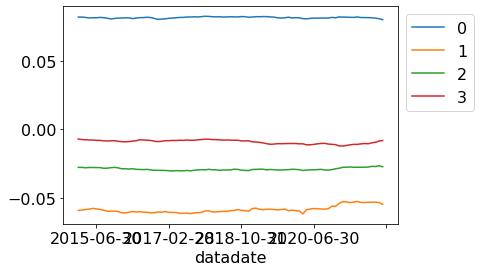

In [395]:
predicted_factors_lst[3].plot()
plt.legend(bbox_to_anchor=(1.25,1))
plt.show()

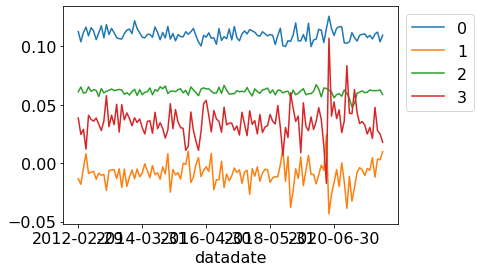

In [396]:
factors_df_lst[4].plot()
plt.legend(bbox_to_anchor=(1.25,1))
plt.show()

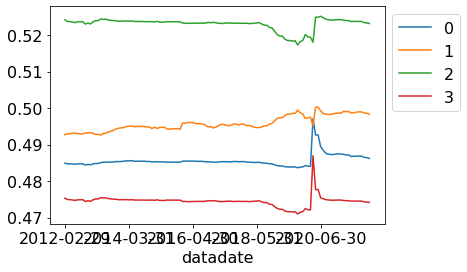

In [397]:
y_macro_df_lst[1].plot()
plt.legend(bbox_to_anchor=(1.25,1))
plt.show()

In [398]:
predicted_returns

,3PBCP,A,AA.3,AABA,AACG,AACH,AADR,AAIC,AAL,AAMC,...,WTAI,XBOC,XBTF,XDEC,XDOC,XLO,XPRO,XTOC,YUMY,ZGEN
datadate,,,,,,,,,,,,,,,,,,,,,
2015-03-31,0.001159,0.001842,0.007339,-0.000861,-0.004705,-0.009928,0.004567,-0.004967,-0.001543,0.004441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,-0.004377,0.001459,0.012223,-0.001160,-0.005291,-0.003103,0.005931,-0.001853,-0.002310,0.003208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,-0.002916,0.004089,0.011375,0.001168,-0.006041,0.006050,0.007048,-0.000913,0.001515,0.003327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,-0.004106,-0.002006,0.011558,0.000920,-0.002089,-0.003894,-0.001671,-0.000037,0.003798,-0.009486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,-0.003582,0.003034,0.010166,-0.001495,-0.008097,0.005880,0.001865,-0.000405,0.003538,-0.009800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30,NaN,0.008788,NaN,NaN,0.009113,NaN,0.003808,-0.003353,0.008431,0.009540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31,NaN,0.005924,NaN,NaN,0.000657,NaN,0.002571,0.003006,0.014561,-0.000379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,NaN,0.006496,NaN,NaN,0.002561,NaN,0.006392,0.005977,0.013922,0.001193,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [399]:
predicted_returns.rank(pct=True,axis=1,numeric_only=True,ascending=True)

,3PBCP,A,AA.3,AABA,AACG,AACH,AADR,AAIC,AAL,AAMC,...,WTAI,XBOC,XBTF,XDEC,XDOC,XLO,XPRO,XTOC,YUMY,ZGEN
datadate,,,,,,,,,,,,,,,,,,,,,
2015-03-31,0.367811,0.420188,0.836121,0.229607,0.088175,0.016579,0.648621,0.082160,0.194689,0.636297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,0.109529,0.413449,0.955513,0.239172,0.084863,0.152841,0.739833,0.204375,0.183673,0.542798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,0.138909,0.578764,0.946764,0.365091,0.062691,0.724073,0.786618,0.228073,0.386473,0.523782,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,0.137306,0.222320,0.975168,0.400088,0.217937,0.145194,0.238095,0.334648,0.643149,0.033158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,0.119830,0.491597,0.939500,0.198451,0.036972,0.721175,0.396610,0.249744,0.529154,0.022212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30,NaN,0.801596,NaN,NaN,0.815064,NaN,0.477491,0.125078,0.785260,0.834269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31,NaN,0.656442,NaN,NaN,0.285088,NaN,0.419306,0.449105,0.961813,0.230500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,NaN,0.626238,NaN,NaN,0.362269,NaN,0.620858,0.591270,0.928475,0.284509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [400]:
predicted_returns.to_csv('LSTM_predicted_returns_lowreg.csv')

In [401]:
def get_sharpes_by_decile(train_pred_dict, metric='sharpe'):
    ranked_sharpes_dict = {}
    for name, train_pred in tqdm(train_pred_dict.items(),total=len(train_pred_dict)):
        train_pred_rank = train_pred.rank(pct=True,axis=1,numeric_only=True,ascending=True)

        ranks = np.arange(0,1,.1)
        ranked_returns = []

        for r in ranks:
            port = ((train_pred_rank >= r) & (train_pred_rank < r+.1)).astype(int)
            port = port.divide(port.sum(axis=1),axis=0)
            port_returns = (port*returns_df.loc[port.index]).sum(axis=1)
            ranked_returns.append(port_returns)
            
        ranked_df = pd.concat(ranked_returns,axis=1)
        ranked_df.columns = ranks
        if metric == 'sharpe':
            ranked_sharpe = ranked_df.mean() / ranked_df.std() * np.sqrt(12)
            ranked_sharpes_dict[name] = ranked_sharpe
        elif metric == 'returns':
            ranked_sharpes_dict[name] = ranked_df.mean() * 12
        elif metric == 'volatility':
            ranked_sharpes_dict[name] = ranked_df.std() * np.sqrt(12)

    return ranked_sharpes_dict

In [402]:
sharpes = get_sharpes_by_decile(
    {'best_model':predicted_returns},
    metric='sharpe'
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

Out of sample Sharpe Ratio (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
LSTM CA,0.447,0.591,0.506,0.461,0.451,0.412,0.335,0.294,0.289,0.168


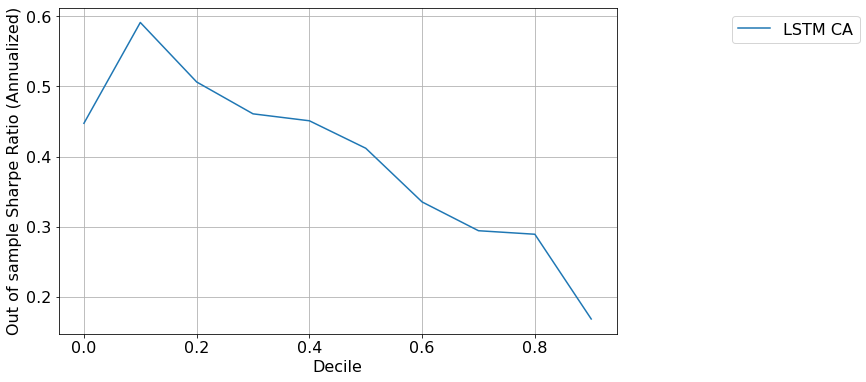

In [403]:
metric = 'sharpe'
ranked_sharpes_dict = get_sharpes_by_decile({'LSTM CA':predicted_returns},metric=metric)
metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.45,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

Out of sample Returns (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
LSTM CA,0.089,0.106,0.084,0.074,0.072,0.067,0.057,0.051,0.052,0.034


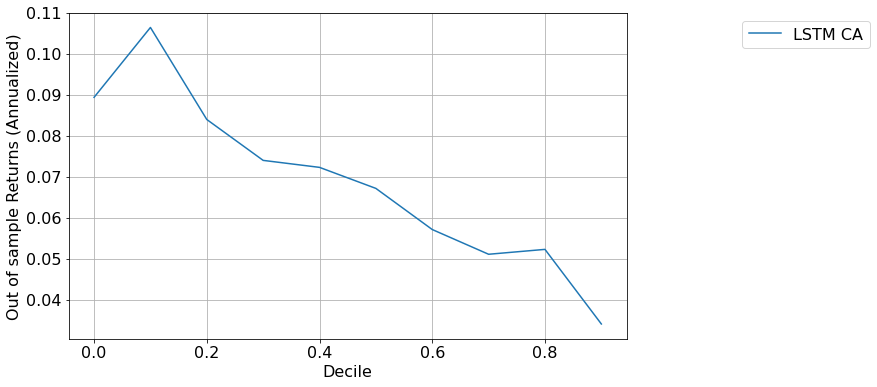

In [404]:
metric = 'returns'
ranked_sharpes_dict = get_sharpes_by_decile({'LSTM CA':predicted_returns},metric=metric)
metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.45,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

Out of sample Volatility (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
LSTM CA,0.2,0.18,0.166,0.161,0.16,0.163,0.17,0.174,0.181,0.202


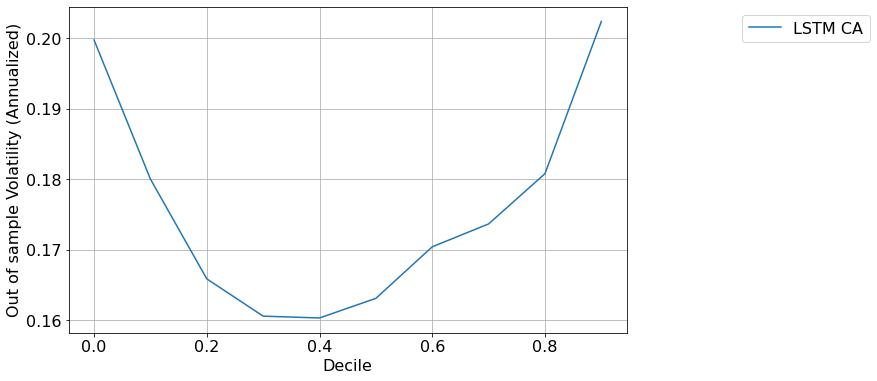

In [405]:
metric = 'volatility'
ranked_sharpes_dict = get_sharpes_by_decile({'LSTM CA':predicted_returns},metric=metric)
metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.45,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

Annualized Return: 0.03410064532447275
Annualized SD: 0.20239783237391906
Annualized Sharpe: 0.1684832536223691


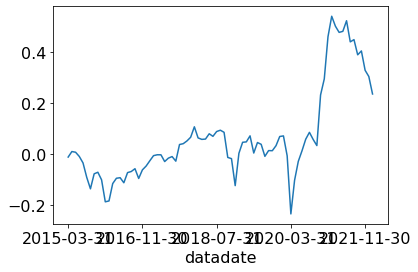

In [406]:
long_port = ((train_pred_rank >= 0.9) & (train_pred_rank < 1)).astype(int)
long_port = long_port.divide(long_port.sum(axis=1),axis=0)
long_port_returns = (long_port*returns_df.loc[long_port.index]).sum(axis=1)
long_port_returns.cumsum().plot()
print("Annualized Return:",long_port_returns.mean()*12)
print("Annualized SD:",long_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(long_port_returns.mean()/long_port_returns.std())*np.sqrt(12))

Annualized Return: 0.08935303221003776
Annualized SD: 0.19975736574122058
Annualized Sharpe: 0.44730782205944697


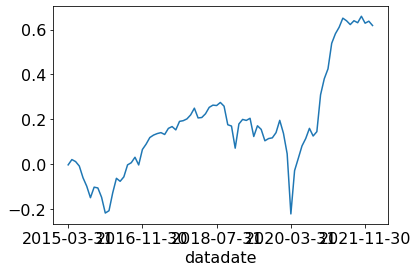

In [407]:
# train_pred_rank = train_pred.rank(pct=True,axis=1,numeric_only=True,ascending=False)
short_port = (train_pred_rank <= 0.1).astype(int)
short_port = short_port.divide(short_port.sum(axis=1),axis=0)
short_port_returns = (short_port*returns_df.loc[short_port.index]).sum(axis=1)
short_port_returns.cumsum().plot()
print("Annualized Return:",short_port_returns.mean()*12)
print("Annualized SD:",short_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(short_port_returns.mean()/short_port_returns.std())*np.sqrt(12))


Annualized Return: -0.055252386885565004
Annualized SD: 0.09889416993651977
Annualized Sharpe: -0.5587021653655776


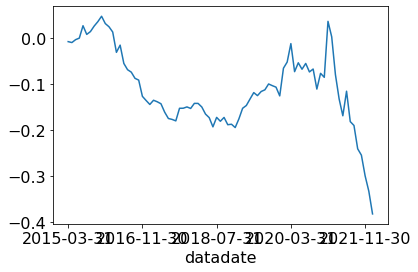

In [408]:
full_port = long_port - short_port
full_port_returns = (full_port*returns_df.loc[full_port.index]).sum(axis=1)
full_port_returns.cumsum().plot()
print("Annualized Return:",full_port_returns.mean()*12)
print("Annualized SD:",full_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(full_port_returns.mean()/full_port_returns.std())*np.sqrt(12))
